# Reconstruction - Phantom model
---

In [1]:
import torch
import numpy             as np
import matplotlib.pyplot as plt

from ipywidgets  import interact
from torch.optim import Adam
from tqdm        import tqdm
from astropy     import constants, units
from pomme.model import TensorModel
from pomme.loss  import Loss, diff_loss, SphericalLoss
from pomme.lines import Line
from pomme.plot  import plot_cube_2D
from pomme.utils import planck, T_CMB

from phantom import lines,fracs, velos, Model

You have selected line:
    CO(J=4-3)
Please check the properties that were inferred:
    Frequency         4.610407682e+11  Hz
    Einstein A coeff  6.126000000e-06  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    sio-h2(J=03-02)
Please check the properties that were inferred:
    Frequency         1.302686830e+11  Hz
    Einstein A coeff  1.058000000e-04  1/s
    Molar mass        44.0849          g/mol


/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


In [2]:
model_truth = TensorModel.load('model_truth.h5')

In [3]:
model = TensorModel(sizes=model_truth.sizes, shape=model_truth.shape)

In [4]:
rs = model.get_radius(origin='centre')

v_in  = 1.0e+2
v_inf = 1.0e+4
beta  = 1.0

T_in    = 5.0e+3
epsilon = 0.5

# Initialise
model['log_H2'          ] = np.log(5.0e+13 * (rs.min()/rs)**2)
# model['log_v_in'        ] = np.log(v_in)
# model['log_v_inf'       ] = np.log(v_inf)
# model['log_beta'        ] = np.log(beta)
model['log_velocity_r'  ] = np.log(v_in + (v_inf - v_in) * (1.0 - rs.min() / rs)**beta)
# model['log_T_in'        ] = np.log(T_in)
# model['log_epsilon'     ] = np.log(epsilon)
model['log_temperature'] = np.log(T_in * (rs.min()/rs)**epsilon)
model['log_v_turbulence'] = np.log(1.5e+2) * np.ones(model.shape, dtype=np.float64)

# model.free(['log_H2', 'log_v_in', 'log_v_inf', 'log_beta', 'log_T_in', 'log_epsilon'])
# model.free(['log_H2', 'log_velocity_r', 'log_T_in', 'log_epsilon'])
model.free(['log_H2', 'log_velocity_r', 'log_temperature'])

losses = Loss(['avg', 'rel', 'reg', 'cnt'])

In [5]:
rs.min() / (1.0 * units.au).si.value

6.720880907034964

In [6]:
# def get_velocity(model):

#     v_in  = torch.exp(model['log_v_in' ])
#     v_inf = torch.exp(model['log_v_inf'])
#     beta  = torch.exp(model['log_beta' ])
    
#     r = torch.from_numpy(model.get_radius(origin='centre'))
#     d = torch.from_numpy(model.get_radial_direction(origin='centre'))
    
#     return (v_in + (v_inf - v_in) * (1.0 - r.min() / r)**beta) * d


def get_velocity(model):
    
    d = torch.from_numpy(model.get_radial_direction(origin='centre'))
    
    return torch.exp(model['log_velocity_r']) * d


# def get_temperature(model):

#     T_in    = torch.exp(model['log_T_in'])
#     epsilon = torch.exp(model['log_epsilon'])    
    
#     r = torch.from_numpy(model.get_radius(origin='centre'))
    
#     return T_in * (r.min() / r)**epsilon

def get_temperature(model):
    
    return torch.exp(model['log_temperature'])


def get_boundary_condition(model, freq):
    Ibdy  = torch.ones((model.shape[0], model.shape[1], len(freq)), dtype=torch.float64)
    Ibdy *= planck(temperature=T_CMB, frequency=freq)
    return Ibdy


pmodel = Model(model, lines, fracs, velos)
pmodel.get_velocity           = get_velocity
pmodel.get_abundance          = lambda model: torch.exp(model['log_H2'])
pmodel.get_turbulence         = lambda model: torch.exp(model['log_v_turbulence'])
pmodel.get_temperature        = get_temperature
pmodel.get_boundary_condition = get_boundary_condition

In [7]:
obss = torch.load('obss.pt')
imgs = pmodel.image()

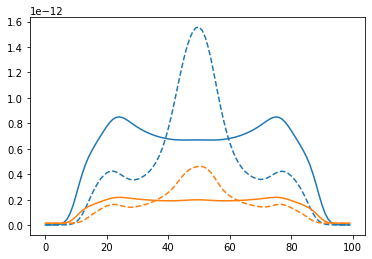

In [8]:
obss_int = obss.sum(axis=(1,2))
imgs_int = imgs.sum(axis=(1,2))

plt.plot(imgs_int[0].data, c='tab:blue')
plt.plot(obss_int[0].data, c='tab:blue', linestyle='--')
plt.plot(imgs_int[1].data, c='tab:orange')
plt.plot(obss_int[1].data, c='tab:orange', linestyle='--')

In [9]:
def steady_state_continuity_loss(pmodel):
    """
    Loss assuming steady state hydrodynamics, i.e. vanishing time derivatives in Euler's equations.
    """
    rho           = pmodel.get_abundance(pmodel.model)
    v_x, v_y, v_z = pmodel.get_velocity (pmodel.model)
    
    # Continuity equation (steady state): div(ρ v) = 0
    loss_cont = pmodel.model.diff_x(rho * v_x) + pmodel.model.diff_y(rho * v_y) + pmodel.model.diff_z(rho * v_z)
    # Squared average over the model
    loss_cont = torch.mean((loss_cont / rho)**2)

    return loss_cont

In [10]:
from torch.optim import Adam
from tqdm        import tqdm


def fit(losses, pmodel, obss, N_epochs=10, lr=1.0e-1, w_avg=1.0, w_rel=1.0, w_reg=1.0, w_cnt=1.0):

    params = [
        pmodel.model['log_H2'],
        # pmodel.model['log_v_in'],
        # pmodel.model['log_v_inf'],
        # pmodel.model['log_beta'],
        pmodel.model['log_velocity_r'],
        # pmodel.model['log_T_in'],
        # pmodel.model['log_epsilon'],
        pmodel.model['log_temperature'],
    ]
    
    optimizer = Adam(params, lr=lr)

    obss_avg= obss.mean(axis=-1)
    obss_rel= torch.einsum("...f, ... -> ...f", obss, 1.0 / obss_avg)

    for _ in tqdm(range(N_epochs)):

        # Forward model
        imgs = pmodel.image()

        imgs_avg= imgs.mean(axis=-1)
        imgs_rel= torch.einsum("...f, ... -> ...f", imgs, 1.0 / imgs_avg)

        # Compute the reproduction loss
        losses['avg'] = w_avg * torch.nn.functional.mse_loss(torch.log(imgs_avg), torch.log(obss_avg))
        losses['rel'] = w_rel * torch.nn.functional.mse_loss(          imgs_rel,            obss_rel )
        # Compute the regularisation loss
        losses['reg'] = w_reg * (  diff_loss(pmodel.model['log_H2'])
                                 + diff_loss(pmodel.model['log_velocity_r'])
                                 + diff_loss(pmodel.model['log_temperature'])
                                )
        # Compute the hydrodynamic loss   
        losses['cnt'] = w_cnt * steady_state_continuity_loss(pmodel)   

        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        losses.tot().backward()
        # Update parameters
        optimizer.step()

    return imgs, losses

In [11]:
pmodel.model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_H2                     Free          True     +2.326e+01     +2.451e+01     +3.154e+01
  log_velocity_r             Free          True     +4.605e+00     +9.178e+00     +9.195e+00
  log_temperature            Free          True     +6.446e+00     +6.759e+00     +8.517e+00
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
sizes: [7.46717267e+13 7.46169581e+13 7.36127621e+13]
shape: (64, 64, 64)


In [12]:
pmodel.model.save('model_fit_it=000.h5')

In [13]:
imgs, losses = fit(losses, pmodel, obss, N_epochs=3, lr=1.0e-1, w_avg=1.0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

losses.renormalise_all()
losses.reset()

  0%|          | 0/3 [00:00<?, ?it/s]/home/frederikd/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 3/3 [00:39<00:00, 13.09s/it]


In [14]:
imgs, losses = fit(losses, pmodel, obss, N_epochs=100, lr=1.0e-1, w_avg=1.0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

100%|██████████| 100/100 [22:19<00:00, 13.39s/it]


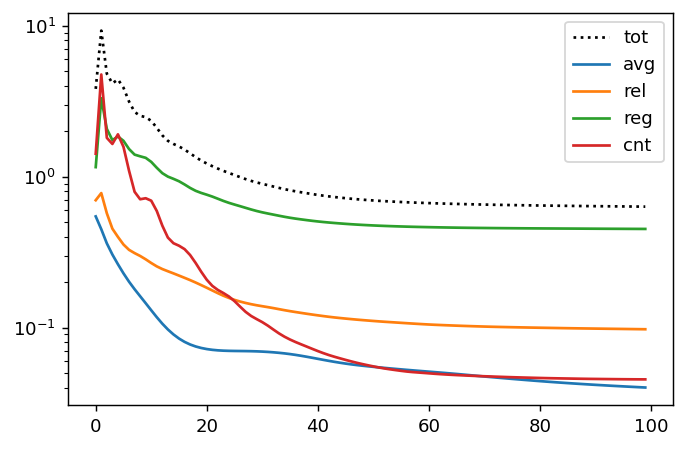

In [15]:
losses.plot()

In [16]:
pmodel.model.save('model_fit_it=100.h5')

In [17]:
imgs, losses = fit(losses, pmodel, obss, N_epochs=100, lr=1.0e-1, w_avg=1.0e+1, w_rel=1.0e+1, w_reg=1.0e+1, w_cnt=1.0e+1)

100%|██████████| 100/100 [23:00<00:00, 13.80s/it]


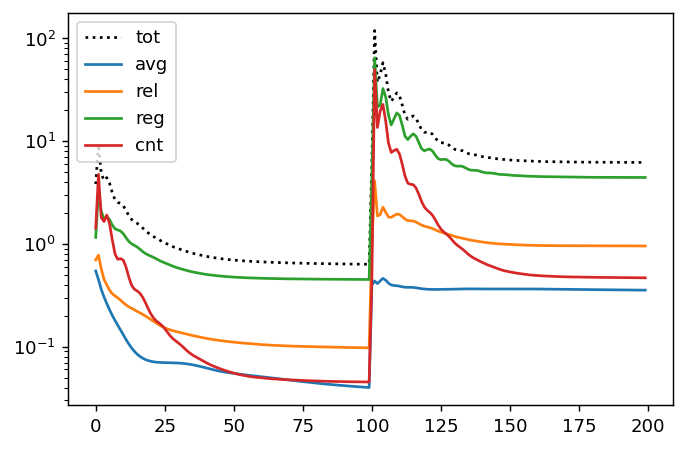

In [18]:
losses.plot()

In [19]:
pmodel.model.save('model_fit_it=200.h5')

In [20]:
imgs, losses = fit(losses, pmodel, obss, N_epochs=100, lr=1.0e-1, w_avg=1.0e+2, w_rel=1.0e+2, w_reg=1.0e+2, w_cnt=1.0e+2)

100%|██████████| 100/100 [23:02<00:00, 13.82s/it]


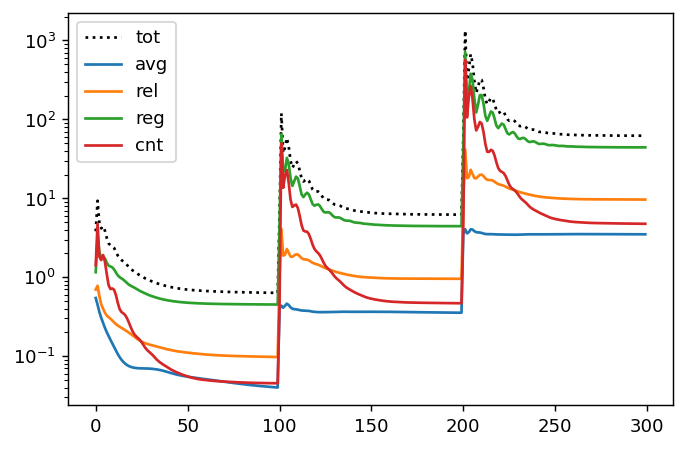

In [21]:
losses.plot()

In [22]:
pmodel.model.save('model_fit_it=300.h5')

In [23]:
imgs, losses = fit(losses, pmodel, obss, N_epochs=100, lr=1.0e-1, w_avg=1.0e+3, w_rel=1.0e+3, w_reg=1.0e+3, w_cnt=1.0e+3)

100%|██████████| 100/100 [23:01<00:00, 13.81s/it]


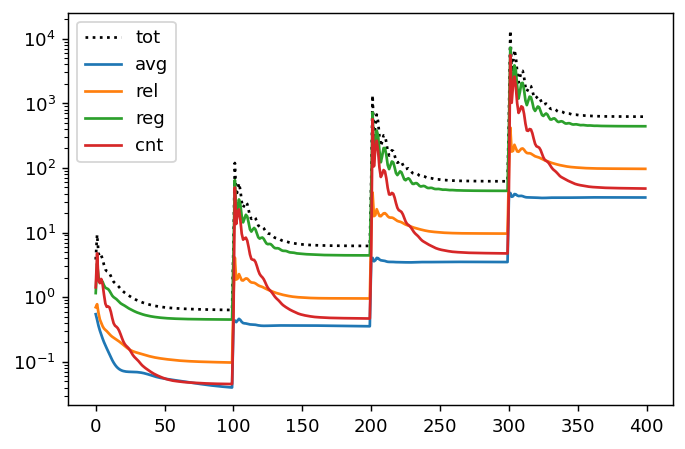

In [24]:
losses.plot()

In [25]:
pmodel.model.save('model_fit_it=400.h5')

In [26]:
# pmodel.model.load('model_fit_it=400.h5')
# pmodel.model.info()

In [27]:
imgs, losses = fit(losses, pmodel, obss, N_epochs=100, lr=1.0e-1, w_avg=1.0e+4, w_rel=1.0e+4, w_reg=1.0e+1, w_cnt=1.0e+3)

100%|██████████| 100/100 [22:43<00:00, 13.63s/it]


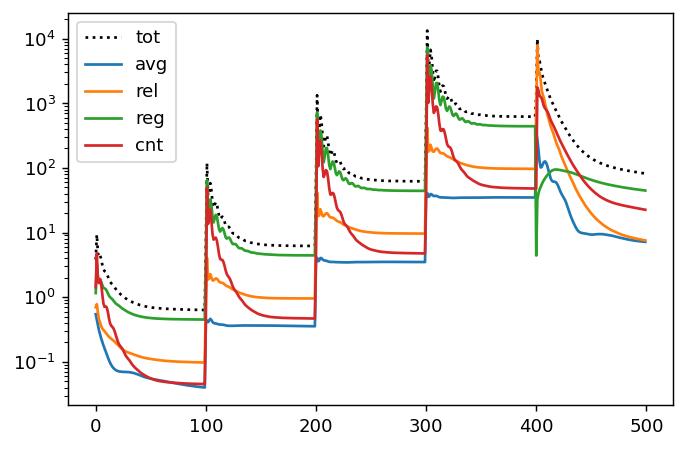

In [28]:
losses.plot()

In [29]:
pmodel.model.save('model_fit_it=500.h5')

In [30]:
imgs, losses = fit(losses, pmodel, obss, N_epochs=100, lr=1.0e-1, w_avg=1.0e+5, w_rel=1.0e+5, w_reg=1.0e+2, w_cnt=1.0e+3)

100%|██████████| 100/100 [23:02<00:00, 13.82s/it]


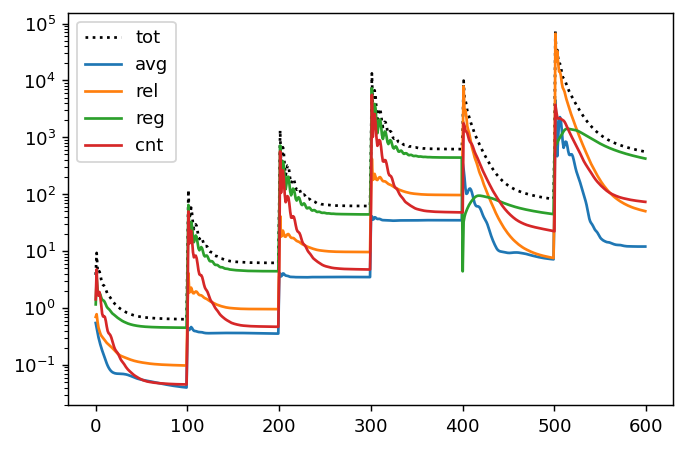

In [31]:
losses.plot()

In [32]:
pmodel.model.save('model_fit_it=600.h5')

In [33]:
imgs, losses = fit(losses, pmodel, obss, N_epochs=100, lr=1.0e-1, w_avg=1.0e+6, w_rel=1.0e+6, w_reg=1.0e+2, w_cnt=1.0e+3)

100%|██████████| 100/100 [24:36<00:00, 14.76s/it]


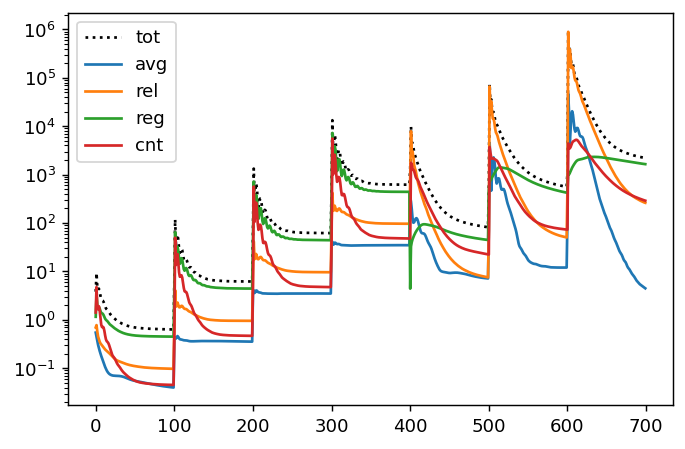

In [34]:
losses.plot()

In [35]:
pmodel.model.save('model_fit_it=700.h5')

In [36]:
imgs, losses = fit(losses, pmodel, obss, N_epochs=100, lr=1.0e-1, w_avg=1.0e+7, w_rel=1.0e+7, w_reg=1.0e+3, w_cnt=1.0e+3)

100%|██████████| 100/100 [26:19<00:00, 15.79s/it]


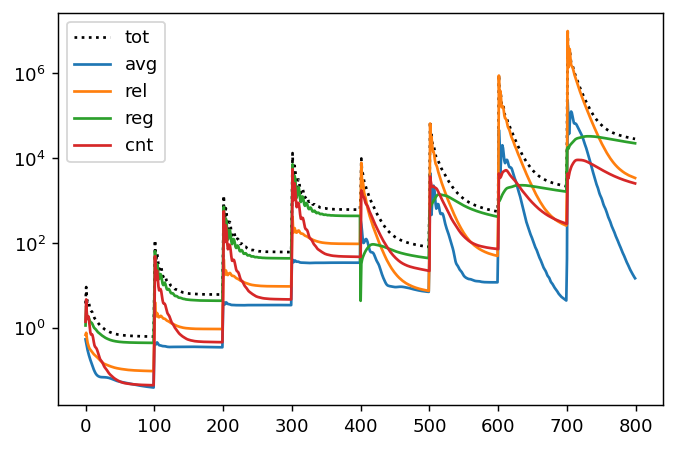

In [37]:
losses.plot()

In [38]:
pmodel.model.save('model_fit_it=800.h5')

In [29]:
# losses.plot()

In [31]:
# print(torch.exp(pmodel.model['log_T_in'   ]).item())
# print(torch.exp(pmodel.model['log_epsilon']).item())
# print(torch.exp(pmodel.model['log_v_in'   ]).item())
# print(torch.exp(pmodel.model['log_v_inf'  ]).item())
# print(torch.exp(pmodel.model['log_beta'   ]).item())

In [32]:
rs  = model_truth.get_radius(origin='centre')
rho       = pmodel.get_abundance  (pmodel.model)
rho_truth = torch.exp(model_truth['log_H2'])
tmp       = pmodel.get_temperature(pmodel.model)
tmp_truth = torch.exp(model_truth['log_temperature'])
vel       = pmodel.get_velocity   (pmodel.model)
v_r       = torch.sqrt(vel[0]**2 + vel[1]**2 + vel[2]**2)
v_r_truth = torch.sqrt(  model_truth['velocity_x']**2
                       + model_truth['velocity_y']**2
                       + model_truth['velocity_z']**2
                    )

In [33]:
nbin = 423

rho_num, rho_xs, rho_ys = np.histogram2d(rs.ravel(), np.log10(rho_truth.data.numpy()).ravel(), bins=(nbin,nbin))
rho_dat = np.log10(rho.data.numpy()).ravel()

tmp_num, tmp_xs, tmp_ys = np.histogram2d(rs.ravel(), np.log10(tmp_truth.data.numpy()).ravel(), bins=(nbin,nbin))
tmp_dat = np.log10(tmp.data.numpy()).ravel()

vel_num, vel_xs, vel_ys = np.histogram2d(rs.ravel(), v_r_truth.data.numpy().ravel(), bins=(nbin,nbin))
vel_dat = v_r.data.numpy().ravel()

/tmp/ipykernel_1221368/526667244.py:3: RuntimeWarning: invalid value encountered in true_divide
  axs[0].imshow(np.flip(np.log(rho_num.T/rho_num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
/tmp/ipykernel_1221368/526667244.py:16: RuntimeWarning: invalid value encountered in true_divide
  axs[1].imshow(np.flip(np.log(tmp_num.T/tmp_num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
/tmp/ipykernel_1221368/526667244.py:29: RuntimeWarning: invalid value encountered in true_divide
  axs[2].imshow(np.flip(np.log(vel_num.T/vel_num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')


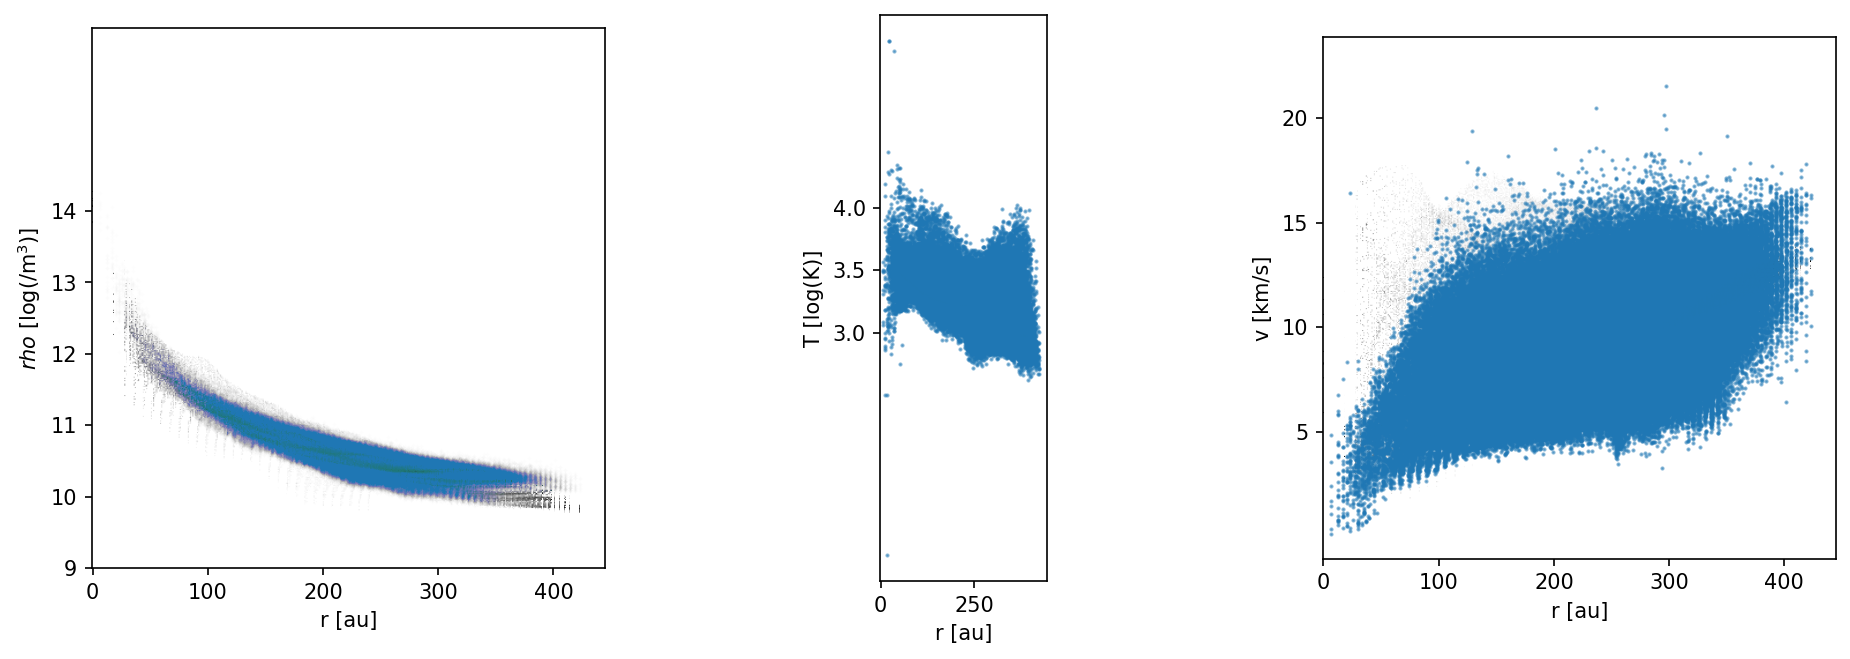

In [34]:
fig, axs = plt.subplots(1, 3, dpi=150, figsize=(15,5))

axs[0].imshow(np.flip(np.log(rho_num.T/rho_num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
axs[0].scatter(
    rs / (1.0 * units.au).si.value,
    len(rho_ys)-(rho_dat-rho_ys[0])/(rho_ys[-1]-rho_ys[0])*len(rho_ys),
    s=1, c='tab:blue', alpha=0.002
)
axs[0].set_xlabel(r'r [au]')
axs[0].set_ylabel(r'$rho$ [log(/m$^{3}$)]')
r_ticks_ls = np.array([9, 10, 11, 12, 13, 14])
r_ticks    = len(rho_ys)-(r_ticks_ls-rho_ys[0])/(rho_ys[-1]-rho_ys[0])*len(rho_ys)
axs[0].set_yticks(r_ticks, r_ticks_ls)


axs[1].imshow(np.flip(np.log(tmp_num.T/tmp_num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
axs[1].scatter(
    rs / (1.0 * units.au).si.value,
    len(tmp_ys)-(tmp_dat-tmp_ys[0])/(tmp_ys[-1]-tmp_ys[0])*len(tmp_ys),
    s=1, c='tab:blue', alpha=0.5
)
axs[1].set_xlabel(r'r [au]')
axs[1].set_ylabel(r'T [log(K)]')
t_ticks_ls = np.array([3, 3.5, 4])
t_ticks    = len(tmp_ys)-(t_ticks_ls-tmp_ys[0])/(tmp_ys[-1]-tmp_ys[0])*len(tmp_ys)
axs[1].set_yticks(t_ticks, t_ticks_ls)


axs[2].imshow(np.flip(np.log(vel_num.T/vel_num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
axs[2].scatter(
    rs / (1.0 * units.au).si.value,
    len(vel_ys)-(vel_dat-vel_ys[0])/(vel_ys[-1]-vel_ys[0])*len(vel_ys),
    s=1, c='tab:blue', alpha=0.5
)
axs[2].set_xlabel(r'r [au]')
axs[2].set_ylabel(r'v [km/s]')
v_ticks_ls = np.array([5, 10, 15, 20])
v_ticks    = len(vel_ys)-(v_ticks_ls*1.0e+3-vel_ys[0])/(vel_ys[-1]-vel_ys[0])*len(vel_ys)
axs[2].set_yticks(v_ticks, v_ticks_ls)

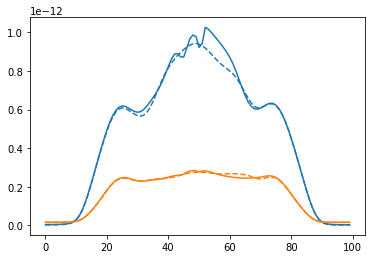

In [35]:
obss_int = obss.sum(axis=(1,2))
imgs_int = imgs.sum(axis=(1,2))

plt.plot(imgs_int[0].data, c='tab:blue')
plt.plot(obss_int[0].data, c='tab:blue', linestyle='--')
plt.plot(imgs_int[1].data, c='tab:orange')
plt.plot(obss_int[1].data, c='tab:orange', linestyle='--')

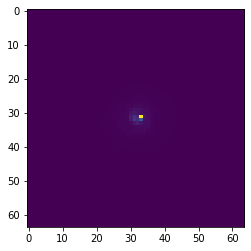

In [36]:
obss_avg= obss.mean(axis=-1)
plt.imshow(obss_avg[1])

In [38]:
plot_cube_2D(torch.log(rho).T)

/tmp/ipykernel_1221368/611157260.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  plot_cube_2D(torch.log(rho).T)


interactive(children=(IntSlider(value=31, description='z', max=63), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [41]:
plot_cube_2D(v_r.T)

interactive(children=(IntSlider(value=31, description='z', max=63), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [101]:
pmodel.model.save('phantom_fit.h5')

In [107]:
v_r.data

tensor([[[12938.9942, 12921.2002, 12903.4650,  ..., 12903.4650,
          12921.2002, 12938.9942],
         [12920.7039, 12902.3533, 12884.0518,  ..., 12884.0518,
          12902.3533, 12920.7039],
         [12902.4590, 12883.5413, 12864.6624,  ..., 12864.6624,
          12883.5413, 12902.4590],
         ...,
         [12902.4590, 12883.5413, 12864.6624,  ..., 12864.6624,
          12883.5413, 12902.4590],
         [12920.7039, 12902.3533, 12884.0518,  ..., 12884.0518,
          12902.3533, 12920.7039],
         [12938.9942, 12921.2002, 12903.4650,  ..., 12903.4650,
          12921.2002, 12938.9942]],

        [[12920.6766, 12902.3251, 12884.0229,  ..., 12884.0229,
          12902.3251, 12920.6766],
         [12901.8131, 12882.8752, 12863.9756,  ..., 12863.9756,
          12882.8752, 12901.8131],
         [12882.9843, 12863.4482, 12843.9386,  ..., 12843.9386,
          12863.4482, 12882.9843],
         ...,
         [12882.9843, 12863.4482, 12843.9386,  ..., 12843.9386,
          12863

In [109]:
pmodel.model['log_velocity_r'] = v_r.data
pmodel.model.free('log_velocity_r')

In [112]:
imgs, losses = fit(losses, pmodel, obss, N_epochs=100, lr=1.0e-1, w_avg=1.0e+5, w_rel=1.0e+5, w_reg=1.0e+2, w_cnt=1.0e+3)

100%|██████████| 100/100 [17:49<00:00, 10.70s/it]


In [118]:
pmodel.model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_H2                     Free          True     +nan     +nan     +nan
  log_v_in                   Free          False    +6.889e+00     +6.889e+00     +6.889e+00
  log_v_inf                  Free          False    +9.600e+00     +9.600e+00     +9.600e+00
  log_beta                   Free          False    +2.185e+00     +2.185e+00     +2.185e+00
  log_T_in                   Free          False    +nan     +nan     +nan
  log_epsilon                Free          False    +nan     +nan     +nan
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
  log_velocity_r             Free          True     +nan     +nan     +nan
sizes: [7.46717267e+13 7.46169581e+13 7.36127621e+13]
shape: (64, 64, 64)


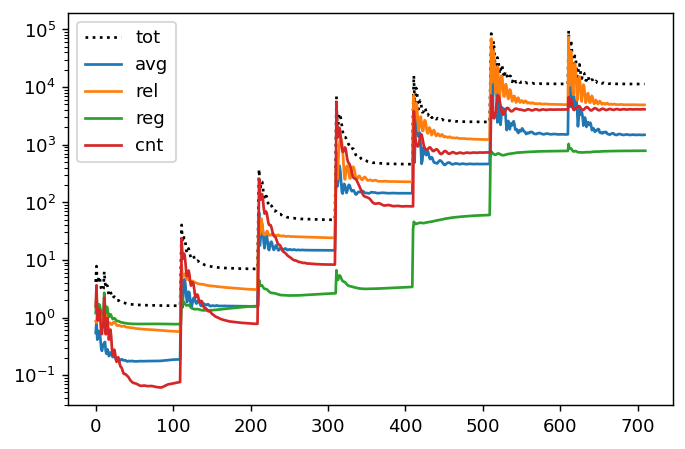

In [113]:
losses.plot()

In [86]:
obss_avg.min()

tensor(1.0374e-17)

In [87]:
obss.max()

tensor(3.4406e-13)

In [33]:
from ipywidgets import interact

def plot(i,j):
    plt.figure(dpi=150)
    plt.plot   (obss[1][i,j,:].data)
    plt.plot   (imgs[1][i,j,:].data, marker='x')
    # plt.yscale('log')
interact(plot, i=(0, imgs[0].shape[0]-1), j=(0, imgs[0].shape[1]-1) )

interactive(children=(IntSlider(value=31, description='i', max=63), IntSlider(value=31, description='j', max=6…

<function __main__.plot(i, j)>

In [74]:
vel_xs

array([1.00542947e+12, 1.15279739e+12, 1.30016530e+12, 1.44753321e+12,
       1.59490113e+12, 1.74226904e+12, 1.88963695e+12, 2.03700487e+12,
       2.18437278e+12, 2.33174069e+12, 2.47910861e+12, 2.62647652e+12,
       2.77384443e+12, 2.92121235e+12, 3.06858026e+12, 3.21594817e+12,
       3.36331609e+12, 3.51068400e+12, 3.65805191e+12, 3.80541983e+12,
       3.95278774e+12, 4.10015565e+12, 4.24752357e+12, 4.39489148e+12,
       4.54225939e+12, 4.68962731e+12, 4.83699522e+12, 4.98436313e+12,
       5.13173105e+12, 5.27909896e+12, 5.42646687e+12, 5.57383478e+12,
       5.72120270e+12, 5.86857061e+12, 6.01593852e+12, 6.16330644e+12,
       6.31067435e+12, 6.45804226e+12, 6.60541018e+12, 6.75277809e+12,
       6.90014600e+12, 7.04751392e+12, 7.19488183e+12, 7.34224974e+12,
       7.48961766e+12, 7.63698557e+12, 7.78435348e+12, 7.93172140e+12,
       8.07908931e+12, 8.22645722e+12, 8.37382514e+12, 8.52119305e+12,
       8.66856096e+12, 8.81592888e+12, 8.96329679e+12, 9.11066470e+12,
      